<a href="https://colab.research.google.com/github/anjha1/Alpha-Thalassemia-Classifier-A-Machine-Learning-Approach/blob/master/Case_Study_2_Alpha_Thalassemia_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from xgboost import cv
from sklearn.model_selection import StratifiedKFold

In [ ]:
import xgboost

In [ ]:
alphanorm = pd.read_csv('/content/alphanorm_anjha.csv', index_col = False)

In [ ]:
alphanorm

,Unnamed: 0,sex,hb,pcv,rbc,mcv,mch,mchc,rdw,wbc,neut,lymph,plt,hba,hba2,hbf,phenotype
0,0,female,10.8,35.2,5.12,68.7,21.2,30.8,13.4,9.6,53.000000,33.000000,309.0,88.500000,2.600000,0.110000,alpha carrier
1,1,male,10.8,26.6,4.28,62.1,25.3,40.8,19.8,10.3,49.400000,43.100000,687.0,87.800000,2.400000,0.900000,alpha carrier
2,2,female,10.8,35.2,5.12,68.7,21.2,30.8,13.4,9.6,53.000000,33.000000,309.0,88.500000,2.600000,0.100000,alpha carrier
3,3,male,14.5,43.5,5.17,84.0,28.0,33.4,12.1,11.9,31.000000,50.000000,334.0,86.800000,2.800000,0.300000,alpha carrier
4,4,male,11.5,34.4,5.02,68.7,22.9,33.4,15.7,20.4,67.000000,30.000000,596.0,86.300000,2.400000,1.300000,alpha carrier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,198,male,15.5,45.9,5.19,88.4,29.9,33.8,12.6,8.8,47.565000,40.975000,177.0,88.600000,3.200000,0.400000,normal
199,199,female,10.4,33.3,4.93,67.6,21.1,31.2,14.8,8.9,44.478378,45.527027,295.0,88.000000,2.400000,0.500000,normal
200,200,male,9.8,29.8,4.75,62.7,19.0,30.4,14.7,7.2,48.234483,41.537931,262.0,85.100000,2.400000,1.100000,normal
201,201,male,11.2,37.2,5.43,68.5,20.6,30.1,15.1,12.0,13.500000,76.800000,277.0,86.523291,2.588608,0.769231,normal


In [ ]:
alphanorm['rbc'] = alphanorm['rbc'].fillna(alphanorm.groupby('phenotype')['rbc'].transform('mean'))
alphanorm['mch'] = alphanorm['mch'].fillna(alphanorm.groupby('phenotype')['mch'].transform('mean'))

In [ ]:
for col in alphanorm.columns:
    if alphanorm[col].dtype != object:
        Q1 = alphanorm[col].quantile(0.25)
        Q3 = alphanorm[col].quantile(0.75)
        IQR = Q3 - Q1
        S = 1.5*IQR
        LB = Q1 - S
        UB = Q3 + S
        print(UB)
        alphanorm.loc[alphanorm[col] > UB,col] = UB
        alphanorm.loc[alphanorm[col] < LB,col] = LB

303.0
17.025000000000002
47.92500000000002
6.537500000000001
104.32500000000003
35.125
36.29074075
19.924999999999997
15.125000000000002
65.875
59.5
564.75
90.61428571249999
3.0000000000000004
1.4730769225


In [ ]:
alphanorm = alphanorm.astype({'sex' : 'category', 'phenotype' : 'category'})

In [ ]:
alphanorm['phenotype'] = alphanorm['phenotype'] == 'alpha carrier'
alphanorm['phenotype'] = alphanorm['phenotype'].replace({True:1, False:0})

<ipython-input-55-e8284ae63eeb>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  alphanorm['phenotype'] = alphanorm['phenotype'].replace({True:1, False:0})


In [ ]:
X = alphanorm.drop('phenotype', axis=1)
y = alphanorm['phenotype']

In [ ]:
X

,Unnamed: 0,sex,hb,pcv,rbc,mcv,mch,mchc,rdw,wbc,neut,lymph,plt,hba,hba2,hbf
0,0,female,10.8,35.2,5.12,68.7,21.2,30.800000,13.4,9.600,53.000000,33.000000,309.00,88.500000,2.600000,0.110000
1,1,male,10.8,26.6,4.28,62.1,25.3,36.290741,19.8,10.300,49.400000,43.100000,564.75,87.800000,2.400000,0.900000
2,2,female,10.8,35.2,5.12,68.7,21.2,30.800000,13.4,9.600,53.000000,33.000000,309.00,88.500000,2.600000,0.100000
3,3,male,14.5,43.5,5.17,84.0,28.0,33.400000,12.1,11.900,31.000000,50.000000,334.00,86.800000,2.800000,0.300000
4,4,male,11.5,34.4,5.02,68.7,22.9,33.400000,15.7,15.125,65.875000,30.000000,564.75,86.300000,2.400000,1.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,198,male,15.5,45.9,5.19,88.4,29.9,33.800000,12.6,8.800,47.565000,40.975000,177.00,88.600000,3.000000,0.400000
199,199,female,10.4,33.3,4.93,67.6,21.1,31.200000,14.8,8.900,44.478378,45.527027,295.00,88.000000,2.400000,0.500000
200,200,male,9.8,29.8,4.75,62.7,19.0,30.400000,14.7,7.200,48.234483,41.537931,262.00,85.100000,2.400000,1.100000
201,201,male,11.2,37.2,5.43,68.5,20.6,30.100000,15.1,12.000,29.275000,59.500000,277.00,86.523291,2.588608,0.769231


In [ ]:
categorical_vars = list((X.select_dtypes(include=['category'])).columns)
categorical_vars

['sex']

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
one_hot = OneHotEncoder()
transformer = ColumnTransformer([('one_hot', one_hot, categorical_vars)],
                                remainder= 'passthrough')
X = pd.DataFrame(transformer.fit_transform(X))

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_index, test_index in split.split(alphanorm, alphanorm["phenotype"]):
    strat_train = alphanorm.loc[train_index]
    strat_test = alphanorm.loc[test_index]

In [ ]:
train_X = strat_train.drop('phenotype', axis=1)
train_y = strat_train['phenotype']
test_x = strat_test.drop('phenotype', axis=1)
test_y = strat_test['phenotype']

In [ ]:
one_hot1 = OneHotEncoder()
transformer = ColumnTransformer([('one_hot', one_hot1, categorical_vars)],
                                remainder= 'passthrough')
train_X = transformer.fit_transform(train_X)
train_X = pd.DataFrame(train_X)

In [ ]:
one_hot2 = OneHotEncoder()
transformer = ColumnTransformer([('one_hot', one_hot2, categorical_vars)],
                                remainder= 'passthrough')
test_x = transformer.fit_transform(test_x)
test_x = pd.DataFrame(test_x)

In [ ]:
train_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.0,0.0,181.0,11.3,35.900000,4.71,76.0,24.0,31.500000,14.0,8.900000,65.875000,29.000000,268.00000,86.523291,2.588608,0.769231
1,1.0,0.0,171.0,11.6,36.000000,4.69,77.0,25.0,32.200000,13.3,7.700000,51.000000,59.500000,249.00000,86.600000,2.500000,0.100000
2,1.0,0.0,95.0,13.8,35.876404,5.81,74.0,23.7,31.600000,11.8,9.900000,53.000000,37.000000,312.00000,87.100000,2.600000,0.100000
3,0.0,1.0,41.0,11.8,36.000000,5.27,68.3,22.4,32.500000,14.8,12.480000,42.000000,51.000000,311.00000,86.600000,2.700000,0.500000
4,0.0,1.0,54.0,13.4,42.600000,5.13,83.0,26.2,31.600000,12.0,7.100000,43.000000,50.000000,235.00000,84.864586,2.679310,0.537931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.0,1.0,93.0,10.6,35.876404,5.55,58.8,18.7,31.900000,16.6,12.300000,30.000000,59.500000,363.00000,86.523291,2.588608,0.769231
158,0.0,1.0,20.0,9.9,32.400000,4.71,68.7,21.0,30.600000,14.9,3.500000,29.275000,59.500000,229.00000,86.900000,2.600000,0.800000
159,0.0,1.0,85.0,15.4,35.876404,6.35,73.6,24.6,32.900000,14.7,9.472529,44.478378,45.527027,332.27957,86.523291,2.588608,0.769231
160,0.0,1.0,77.0,10.9,33.700000,4.32,77.9,25.3,28.705556,16.4,12.500000,44.478378,45.527027,443.00000,87.000000,2.500000,0.500000


In [ ]:
from sklearn import preprocessing
train_X = preprocessing.normalize(train_X)
test_x = preprocessing.normalize(test_x)



In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
train_X, train_y = sm.fit_resample(train_X, train_y)

In [ ]:
train_y.value_counts()

,count
phenotype,
0,118
1,118


In [ ]:
!pip install optuna

from sklearn.metrics import roc_auc_score
import optuna
from xgboost import XGBClassifier



In [ ]:
import xgboost

In [ ]:
xgboost.__version__

'2.1.2'

In [ ]:
import joblib
joblib.__version__

'1.4.2'

In [ ]:
from sklearn.metrics import f1_score

Hyperparameter tuning with Optuna - we are using Recall as the metric, because the most important function of the model is to identify alpha thalassemia carriers

In [ ]:
def run(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.3, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)




    model = XGBClassifier(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_estimators=7000,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,

    )
    model.fit(train_X, train_y, early_stopping_rounds=15, eval_set=[(test_x, test_y)], verbose=1000)
    preds_valid = model.predict(test_x)
    f1 = f1_score(test_y, preds_valid)
    return f1

In [ ]:
!pip install optuna
!pip install xgboost

In [ ]:
def run(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.3, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)




    model = XGBClassifier(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_estimators=7000,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        eval_metric='logloss'
    )
    model.fit(train_X, train_y, early_stopping_rounds=15, eval_set=[(test_x, test_y)], verbose=1000)
    preds_valid = model.predict(test_x)
    f1 = f1_score(test_y, preds_valid)
    return f1

In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score


def run(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.3, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)




    model = XGBClassifier(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_estimators=7000,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        eval_metric='logloss'
    )

In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import xgboost as xgb

def run(trial):

    early_stopping = xgb.callback.EarlyStopping(rounds=15, metric_name='logloss', data_name='validation_0')

    def early_stopping_verbose_eval(env):
        if env.iteration % 1000 == 0:
            print(f"Iteration: {env.iteration}, Logloss: {env.evaluation_result_list[0][1]}")


    model.fit(
        train_X,
        train_y,
        eval_set=[(test_x, test_y)],
        callbacks=[early_stopping, early_stopping_verbose_eval],
    )



In [ ]:
params = {}
params['max_depth'] = 2

In [ ]:
params['learning_rate'] = 0.155

In [ ]:
final_params = params
final_params = {'learning_rate': 0.155,
 'reg_lambda': 0.011013949800760672,
 'reg_alpha': 1.7383948002073539e-07,
 'subsample': 0.7109839223765275,
 'colsample_bytree': 0.5955752711372541,
 'max_depth': 4}

In [ ]:
import xgboost as xgb


xgbmodel = xgb.XGBClassifier(

    eval_metric=["error", "logloss"]
)

xgbmodel.fit(train_X, train_y,
            eval_set=[(train_X, train_y), (test_x, test_y)],
            verbose=True)

booster = xgbmodel.get_booster()



[0]	validation_0-error:0.02966	validation_0-logloss:0.47415	validation_1-error:0.09756	validation_1-logloss:0.51587
[1]	validation_0-error:0.02542	validation_0-logloss:0.35093	validation_1-error:0.07317	validation_1-logloss:0.42604
[2]	validation_0-error:0.01271	validation_0-logloss:0.26567	validation_1-error:0.09756	validation_1-logloss:0.36520
[3]	validation_0-error:0.00424	validation_0-logloss:0.20815	validation_1-error:0.09756	validation_1-logloss:0.32309
[4]	validation_0-error:0.00424	validation_0-logloss:0.16070	validation_1-error:0.07317	validation_1-logloss:0.27926
[5]	validation_0-error:0.00424	validation_0-logloss:0.12884	validation_1-error:0.07317	validation_1-logloss:0.24850
[6]	validation_0-error:0.00424	validation_0-logloss:0.10383	validation_1-error:0.07317	validation_1-logloss:0.22406
[7]	validation_0-error:0.00424	validation_0-logloss:0.08606	validation_1-error:0.04878	validation_1-logloss:0.19233
[8]	validation_0-error:0.00424	validation_0-logloss:0.07187	validation_1

In [ ]:
import joblib
joblib.dump(xgbmodel, 'XGB.pkl')

['XGB.pkl']

In [ ]:
from sklearn.metrics import classification_report
y_preds = xgbmodel.predict(test_x)
print(classification_report(y_preds, test_y))


              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.97      1.00      0.98        29

    accuracy                           0.98        41
   macro avg       0.98      0.96      0.97        41
weighted avg       0.98      0.98      0.98        41



In [ ]:
roc_auc_score(y_preds, test_y)

0.9583333333333333

In [ ]:
train_preds = xgbmodel.predict(train_X)
print(classification_report(train_preds, train_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00       118

    accuracy                           1.00       236
   macro avg       1.00      1.00      1.00       236
weighted avg       1.00      1.00      1.00       236



In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_y, y_preds)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.97      1.00      0.98        29

    accuracy                           0.98        41
   macro avg       0.98      0.96      0.97        41
weighted avg       0.98      0.98      0.98        41



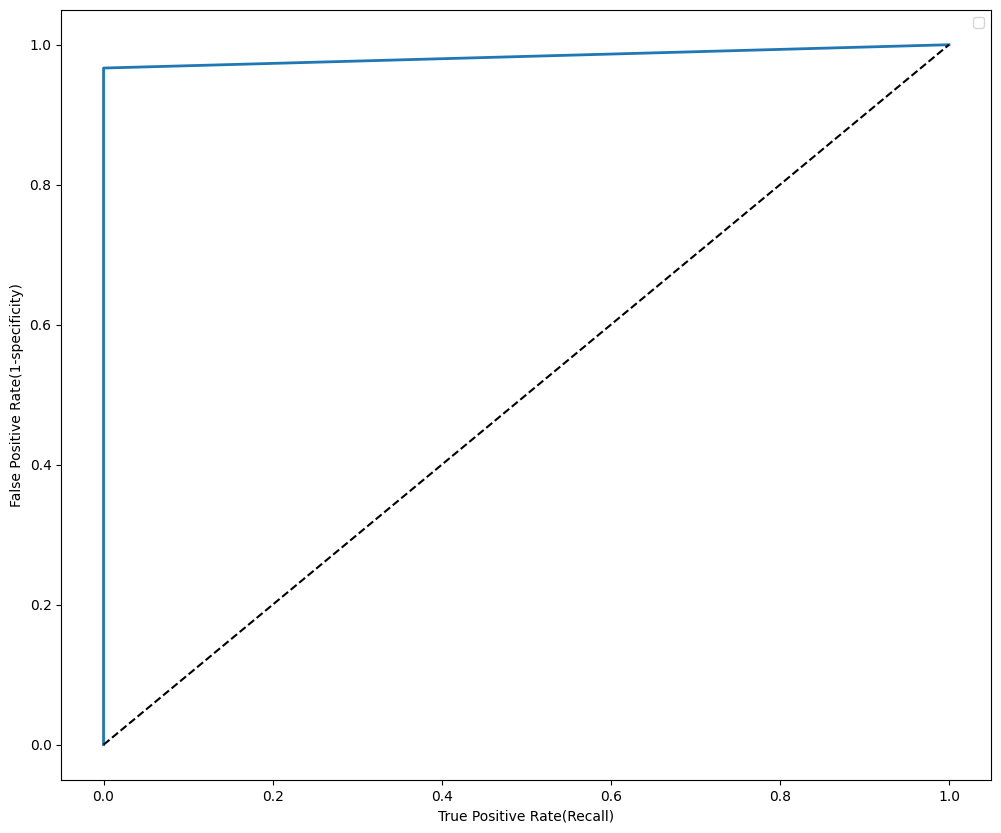

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

y_preds = xgbmodel.predict(test_x)
print(classification_report(y_preds, test_y))



def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('True Positive Rate(Recall)')
    plt.ylabel("False Positive Rate(1-specificity)")
    plt.legend()

plot_roc_curve(fpr, tpr)

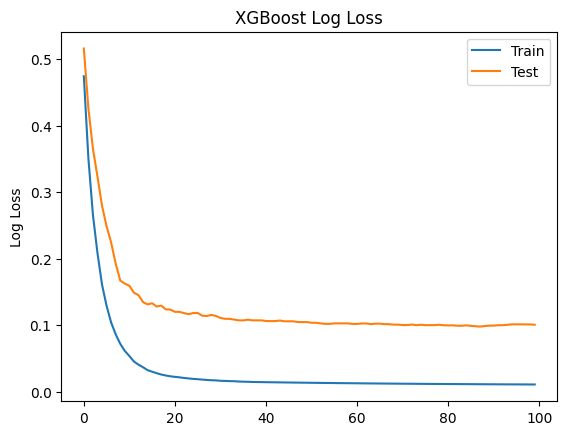

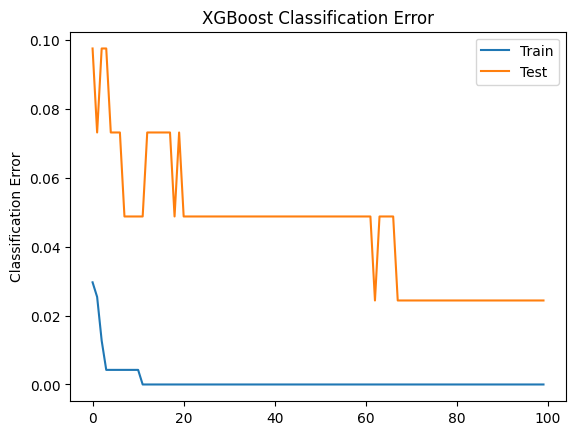

In [ ]:
#plotting train error rate and test error rate to assess overfitting


import matplotlib.pyplot as plt
results = xgbmodel.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

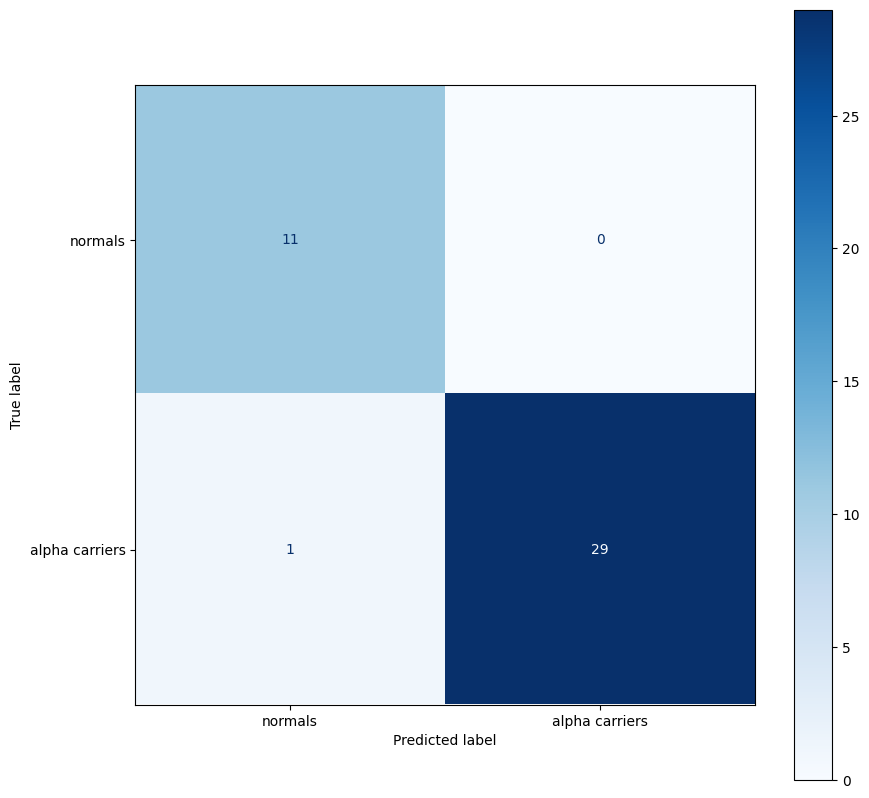

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax =plt.subplots(figsize=(10, 10))
cm = confusion_matrix(test_y, xgbmodel.predict(test_x))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normals', 'alpha carriers'])
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
test_x.shape

(41, 17)

In [ ]:
import joblib
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import f1_score

# Define your model training function
def run(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.3, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)

    model = XGBClassifier(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_estimators=7000,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )


    model.fit(train_X, train_y, early_stopping_rounds=15, eval_set=[(test_x, test_y)], verbose=1000)



    # Make predictions and calculate F1 score
    preds_valid = model.predict(test_x)
    f1 = f1_score(test_y, preds_valid)
    return f1


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import pickle

df = pd.read_csv('/content/alphanorm_anjha.csv')


print("Dataset head:")
print(df.head())


if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
if 'sex' in df.columns:
    df.drop('sex', axis=1, inplace=True)

le = LabelEncoder()
df['phenotype'] = le.fit_transform(df['phenotype'])


X = df.drop('phenotype', axis=1)
y = df['phenotype']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


with open('model.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)


with open('label_encoder.pkl', 'wb') as encoder_file:
    pickle.dump(le, encoder_file)

print("Model and label encoder saved successfully!")


Dataset head:
   Unnamed: 0     sex    hb   pcv   rbc   mcv   mch  mchc   rdw   wbc  neut  \
0           0  female  10.8  35.2  5.12  68.7  21.2  30.8  13.4   9.6  53.0   
1           1    male  10.8  26.6  4.28  62.1  25.3  40.8  19.8  10.3  49.4   
2           2  female  10.8  35.2  5.12  68.7  21.2  30.8  13.4   9.6  53.0   
3           3    male  14.5  43.5  5.17  84.0  28.0  33.4  12.1  11.9  31.0   
4           4    male  11.5  34.4  5.02  68.7  22.9  33.4  15.7  20.4  67.0   

   lymph    plt   hba  hba2   hbf      phenotype  
0   33.0  309.0  88.5   2.6  0.11  alpha carrier  
1   43.1  687.0  87.8   2.4  0.90  alpha carrier  
2   33.0  309.0  88.5   2.6  0.10  alpha carrier  
3   50.0  334.0  86.8   2.8  0.30  alpha carrier  
4   30.0  596.0  86.3   2.4  1.30  alpha carrier  
Model and label encoder saved successfully!


In [ ]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Seaborn version:", sns.__version__)


NumPy version: 1.26.4
Pandas version: 2.2.2
Scikit-learn version: 1.5.2
Seaborn version: 0.13.2


In [ ]:
import xgboost as xgb

print("XGBoost version:", xgb.__version__)


XGBoost version: 2.1.2


****87% sensitivity in identifying alpha carriers! Also only 3 out of 11 normals in test set are wrongly classified :)**